# Análise e predição da ocorrência de AVC 
UFPB

Disciplina: Introdução à Ciência de Dados

Professor: Yuri Malheiros

Projeto realizado como requisito parcial para conclusão da disciplina de ICD

Alunos: 

    Deivison Rodrigues Jordão
    Lucas Miranda de Aguiar
    Filipe de Medeiros Santos
    

## Introdução:

Este projeto nasce da necessidade de uma maior compreensão dos dados de pacientes com avc disponíveis publicamente sob um ponto de vista estatístico. 
Com os seguintes objetivos:
- Compreender os dados obtidos;
- Buscar relações que possibilitem a definição de padrões de ocorrência do avc;
- Aplicar um modelo de aprendizagem de máquina com o fulcro de predizer a probabilidade de ocorrência de um avc.

Importando as bibliotecas e o dataset:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
db = pd.read_csv("healthcare-dataset-stroke-data.csv")
db

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Limpeza e Transformação dos Dados

In [3]:
db.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [4]:
db["bmi"].isnull().sum()

201

In [5]:
db.dropna(inplace=True)

db.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

In [6]:
db.smoking_status.value_counts()

never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64

In [7]:
db.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
db = db.astype({"age": int})

db.age

0       67
2       80
3       49
4       79
5       81
        ..
5104    13
5106    81
5107    35
5108    51
5109    44
Name: age, Length: 4909, dtype: int32

In [9]:
db.ever_married.unique()

array(['Yes', 'No'], dtype=object)

In [10]:
db.ever_married = db.ever_married.map({'Yes': 1, 'No': 0})

db.ever_married

0       1
2       1
3       1
4       1
5       1
       ..
5104    0
5106    1
5107    1
5108    1
5109    1
Name: ever_married, Length: 4909, dtype: int64

As colunas que passaram pelos processos de limpeza e transformação de seus dados foram as seguintes:

1. BMI: dado a existência de 201 linhas com dados faltantes, foi realizada a retiradas das respectivas entradas;
2. Smoking Status: nesta coluna foi verificada a existência do valor categórico unknown, contudo, dada a quantidade de ocorrência tais entradas permaneceram inalteradas;
3. Age: os dados presentes nesta coluna tiveram seu tipo alterado de float para int, possibilitando maior eficiência posteriormente;
4. Ever Married: dado que os únicos valores presentes são 'Yes' e 'No', logo, para facilitar a futura manipulação, as entradas foram substituídas para 1 e 0, respectivamente.

## Análise Exploratória

Algumas das colunas do dataset trabalhadas em seguida dispõem de dados categóricos, tornando inviável a aplicação de medidas de centralidade e dispersão a essas colunas. Desta forma, será feita uma análise exploratória inicial com base na contagem da ocorrência dos valores categóricos e o uso de gráficos para facilitar a visualização e entendimento dos dados.

A partir da análise exploratória realizada nessa seção será respondida a seguinte pergunta:

**Os dados estão bem distribuídos de acordo com as variáveis nas colunas?**

In [11]:
# Declarando função para calcular medidas de centralidade e dispersão do dataset

def medidas(data):
    mean = np.mean(data)
    median = data.median()
    variance = np.var(data)
    std_deviation = np.std(data)
    dict_medidas = {"Média":mean,"Mediana":median,"Variância":variance,"Desvio Padrão":std_deviation}
    return pd.DataFrame(dict_medidas).T

### 1. Idade

#### 1.1 Idade Geral

In [12]:
stroke_1 = db[db["stroke"] == 1]
stroke_0 = db[db["stroke"] == 0]

Definindo o database que vai ser usado nos modelos de machine learning para que ele faça referencia ao database original sem sofrer alguma alteração:

In [13]:
pred_db = pd.concat([stroke_0[400:609], stroke_1])

In [14]:
age = db[["age"]]

medidas(age)

,age
Média,42.854145
Mediana,44.000000
Variância,509.571311
Desvio Padrão,22.573686


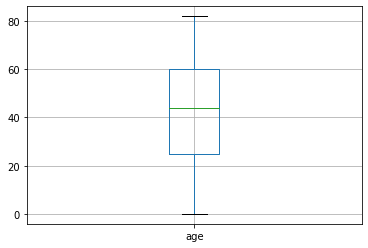

In [15]:
age.boxplot();

#### 1.2 Idade dos indivíduos que sofreram AVC

In [16]:
age_1 = stroke_1[["age"]]
medidas(age_1)

,age
Média,67.712919
Mediana,70.000000
Variância,153.094618
Desvio Padrão,12.373141


Temos que a média aumenta consideravelmente, e se concentrando entre os idosos

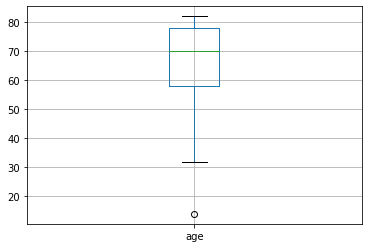

In [17]:
age_1.boxplot();

#### 1.3 Idades dos indivíduos que não sofreram AVC

In [18]:
age_0 = stroke_0[["age"]]
medidas(age_0)

,age
Média,41.748723
Mediana,43.000000
Variância,496.721754
Desvio Padrão,22.287255


<AxesSubplot:>

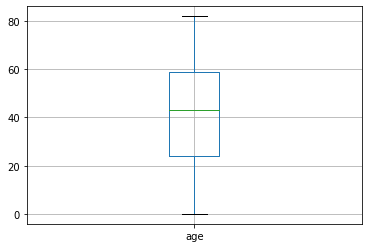

In [19]:
age_0.boxplot()

Distribuição dos dados: conforme as análises realzadas com referencia à idade observa-se uma concentração divergente dos dados das pessoas que tiveram ou não AVC, conforme a seguir:
 - Tiveram AVC (60-80);
 - Não tiveram AVC (20-60).

### 2. Relação com a hipertensão

#### 2.1 Hipertensão geral

In [20]:
hypertension = db[["hypertension"]].value_counts()
hypertension

hypertension
0               4458
1                451
dtype: int64

#### 2.2 Relação entre quem tem hipertensão e tiveram avc

In [21]:
hypertension_1 = stroke_1["hypertension"].value_counts()
hypertension_1

0    149
1     60
Name: hypertension, dtype: int64

#### 2.3 Relação entre hipertensão e não tiveram avc

In [22]:
hypertension_0 = stroke_0["hypertension"].value_counts()
hypertension_0

0    4309
1     391
Name: hypertension, dtype: int64

Distribuição dos dados: conforme a distribuição verificada acima com referencia à comorbidade da hipertensão observa-se uma concentração menor deste atributo nos dados das pessoas que não tiveram AVC, numa proporção de:
 - Tiveram AVC: 29%
 - Não tiveram AVC: 8%

### 3. Nível de Glicose

#### 3.1 Nível de Glicose Geral

In [23]:
glicose = db[["avg_glucose_level"]]
medidas(glicose)

,avg_glucose_level
Média,105.305150
Mediana,91.680000
Variância,1973.120022
Desvio Padrão,44.419816


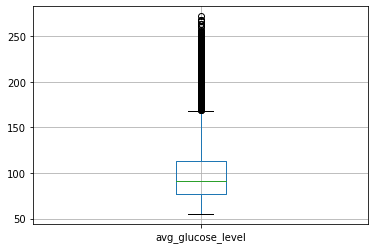

In [24]:
glicose.boxplot();

#### 3.2 Nivel de glicose dos indivíduos que sofreram AVC

In [25]:
glicose_1 = stroke_1[["avg_glucose_level"]]
medidas(glicose_1)

,avg_glucose_level
Média,134.571388
Mediana,106.580000
Variância,3882.839798
Desvio Padrão,62.312437


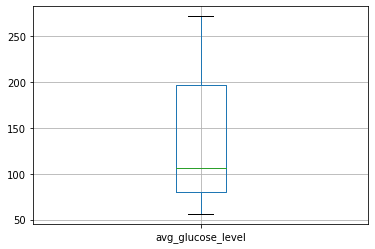

In [26]:
glicose_1.boxplot();

#### 3.3 Nivel de glicose dos indivíduos que não sofreram AVC

In [27]:
glicose_0 = stroke_0[["avg_glucose_level"]]
medidas(glicose_0)

,avg_glucose_level
Média,104.003736
Mediana,91.210000
Variância,1848.417285
Desvio Padrão,42.993224


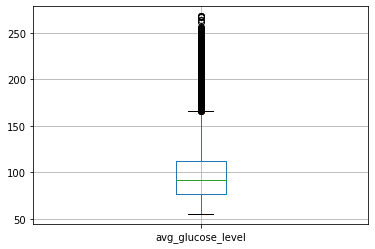

In [28]:
glicose_0.boxplot();

Observa-se uma média  mais alta de glicose nos indivíduos que tiveram avc com relação aos que não tiveram. Percebe-se também presença de outliers nos que não tiveram avc, demostrando uma má distribuição deste atributo.

Em relação a este atributo os dados estão coerentes com relação a ocorrência do avc, dado que os dados dos indivíduos que não tiveram AVC se concentram numa faixa de glicose menor e saudável entre 76 e 112, enquanto os que tiveram AVC numa faixa mais ampla (abrangente do status diabético) entre 80 e 196.

### 4. Com Relação ao Hábito de Fumar

In [29]:
smoking_status = db["smoking_status"].value_counts()
smoking_status

never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64

#### 4.1 Status de fumantes que tiveram avc

In [30]:
smoke_status_1 = stroke_1["smoking_status"].value_counts().T
smoke_status_1

never smoked       84
formerly smoked    57
smokes             39
Unknown            29
Name: smoking_status, dtype: int64

In [31]:
84/209

0.4019138755980861

#### 4.2 Status de fumante que não tiveram avc

In [32]:
smoke_status_0 = stroke_0["smoking_status"].value_counts().T
smoke_status_0

never smoked       1768
Unknown            1454
formerly smoked     780
smokes              698
Name: smoking_status, dtype: int64

In [33]:
1454/1483

0.9804450438300741

A observação mais relevante em relação a este atributo é a discrepância na presença do status "Unknown"  nos indivíduos que não tiveram AVC (98%).

### 5. Em Relação a Localidade

#### 5.1 De todo o dataset

In [34]:
residence = db["Residence_type"].value_counts().T
residence

Urban    2490
Rural    2419
Name: Residence_type, dtype: int64

#### 5.2 Pessoas que não sofreram ataque cardíaco e sua localidade

In [35]:
residence_0 = stroke_0["Residence_type"].value_counts().T
residence_0

Urban    2381
Rural    2319
Name: Residence_type, dtype: int64

Podemos ver que os moradores que não sofreram ataque cardíacos estão bem distribuídas:

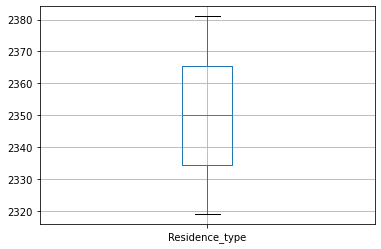

In [36]:
residence_0.to_frame().boxplot();

#### 5.3 Pessoas que sofreram AVC e sua localidade

In [37]:
residence_1 = stroke_1["Residence_type"].value_counts()
residence_1

Urban    109
Rural    100
Name: Residence_type, dtype: int64

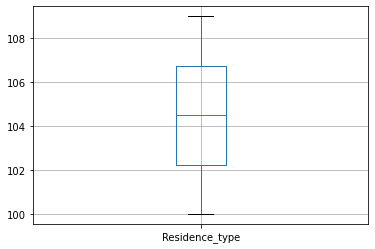

In [38]:
residence_1.to_frame().boxplot();

Nesta subseção foi observada uma distribuição uniforme dos dados.

### 6. Em Relação ao IMC

#### 6.1 De todo o dataset

In [39]:
bmi = db["bmi"].to_frame()
medidas(bmi)

,bmi
Média,28.893237
Mediana,28.100000
Variância,61.673798
Desvio Padrão,7.853267


#### 6.2 IMC de pessoas que não tiveram ataque cardíaco

In [40]:
bmi_0 = stroke_0['bmi'].to_frame()
bmi_0.head()

,bmi
249,18.0
250,39.2
251,17.6
252,35.9
253,19.1


In [41]:
medidas(bmi_0)

,bmi
Média,28.823064
Mediana,28.000000
Variância,62.527698
Desvio Padrão,7.907446


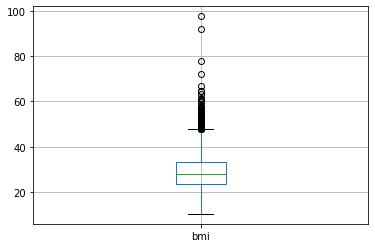

In [42]:
# Presença de vários outliers

bmi_0.boxplot();

#### 6.3 IMC de pessoas que tiveram avc

In [43]:
bmi_1 = stroke_1['bmi'].to_frame();bmi_1

,bmi
0,36.6
2,32.5
3,34.4
4,24.0
5,29.0
...,...
243,40.5
244,36.7
245,30.9
246,29.3


In [44]:
# Os dados não tem tanta variação, o que facilita o entendimento

medidas(bmi_1)

,bmi
Média,30.471292
Mediana,29.700000
Variância,39.870276
Desvio Padrão,6.314291


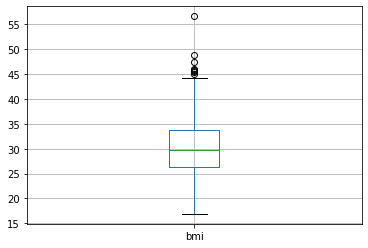

In [45]:
bmi_1.boxplot();

Nesta subseção foi observada uma distribuição uniforme dos dados.

### 7. Em Relação à doença cardíaca (heart disease)

#### 7.1 De todo o dataset

In [46]:
heart_disease = db["heart_disease"].value_counts().to_frame()
heart_disease.rename({0: "No stroke", 1:"stroke"}, axis='index', inplace=True)

heart_disease["heart_disease_perc"] =  heart_disease["heart_disease"] / heart_disease["heart_disease"].sum() * 100
heart_disease

,heart_disease,heart_disease_perc
No stroke,4666,95.049908
stroke,243,4.950092


#### 7.2 Doença cardíaca e sua influencia no avc

In [47]:
heart_disease_0 = db[db.stroke == 0]
heart_disease_0 = heart_disease_0["heart_disease"].value_counts()
heart_disease_1 = db[db.stroke == 1]
heart_disease_1 = heart_disease_1["heart_disease"].value_counts()

heart = pd.DataFrame({"Tiveram AVC": heart_disease_1,
                     "Não teve Avc": heart_disease_0})
heart = heart.rename({1: "Teve doença cardíaca", 0: "Não teve doença cardíaca"}, axis='index')

heart

,Tiveram AVC,Não teve Avc
Não teve doença cardíaca,169,4497
Teve doença cardíaca,40,203


A relação dos indivíduos que possuem a comorbidade de doença cardíaca em percentual está discriminada a seguir:
- 4% nos indivíduos que não tiveram AVC
- 19% nos indivíduos que tiveram AVC

Cerca de 15% a mais.

### 8. Em Relação à Coluna Gênero

In [48]:
gender = db["gender"]
gender.head()

0      Male
2      Male
3    Female
4    Female
5      Male
Name: gender, dtype: object

In [49]:
# Verificando a prevalência de gênero na base de dados

gender = gender.value_counts().to_frame()
gender

,gender
Female,2897
Male,2011
Other,1


In [50]:
# Incluindo a porcentagem de ocorrência por gênero

gender["gender_perc"] = gender["gender"] / gender["gender"].sum() * 100
gender

,gender,gender_perc
Female,2897,59.014056
Male,2011,40.965573
Other,1,0.020371


In [51]:
gender_1 = stroke_1["gender"]
gender_1.head()

0      Male
2      Male
3    Female
4    Female
5      Male
Name: gender, dtype: object

In [52]:
gender["gender_1"] = gender_1.value_counts()
gender["gender_perc_1"] = gender["gender_1"] / gender["gender_1"].sum() * 100

gender

,gender,gender_perc,gender_1,gender_perc_1
Female,2897,59.014056,120.0,57.416268
Male,2011,40.965573,89.0,42.583732
Other,1,0.020371,NaN,NaN


In [53]:
# Incluindo uma coluna com relação por gênero dos indivíduos que não tiveram AVC

gender['gender_0'] = gender['gender'] - gender['gender_1']
gender

,gender,gender_perc,gender_1,gender_perc_1,gender_0
Female,2897,59.014056,120.0,57.416268,2777.0
Male,2011,40.965573,89.0,42.583732,1922.0
Other,1,0.020371,NaN,NaN,NaN


Nesta subseção foi observada uma distribuição uniforme dos dados.

### 9. Em Relação ao Estado Civil

In [54]:
married = db["ever_married"].map({1: 'Casou', 0: 'Não casou'})
married.head()

0    Casou
2    Casou
3    Casou
4    Casou
5    Casou
Name: ever_married, dtype: object

In [55]:
# Verificando a prevalência de pessoas que já foram casadas na base de dados

married = married.value_counts().to_frame()
married

,ever_married
Casou,3204
Não casou,1705


In [56]:
# Incluindo a porcentagem de ocorrência

married["married_perc"] = married["ever_married"] / married["ever_married"].sum() * 100
married

,ever_married,married_perc
Casou,3204,65.267875
Não casou,1705,34.732125


In [57]:
married_1 = stroke_1["ever_married"].map({1:'Casou', 0:'Não casou'})
married_1.head()

0    Casou
2    Casou
3    Casou
4    Casou
5    Casou
Name: ever_married, dtype: object

In [58]:
# Verificando a prevalência de pessoas que já foram casadas nas entradas em que houveram a ocorrência de AVC
# Incluindo a porcentagem no dataframe

married["ever_married_1"] = married_1.value_counts()
married["married_perc_1"] = married["ever_married_1"] / married["ever_married_1"].sum() * 100

married

,ever_married,married_perc,ever_married_1,married_perc_1
Casou,3204,65.267875,186,88.995215
Não casou,1705,34.732125,23,11.004785


Com relação ao atributo que diz respeito a contrair matrimônio, o percentual geral nos indivíduos pesquisados é maior com
relação aos casados, contudo, essa prevalência aumenta de 65% para 89% nos que tiveram avc

### 10. Tipo de Trabalho 

In [59]:
work = db["work_type"]
work.head()

0          Private
2          Private
3          Private
4    Self-employed
5          Private
Name: work_type, dtype: object

In [60]:
work = work.value_counts().to_frame()
work

,work_type
Private,2811
Self-employed,775
children,671
Govt_job,630
Never_worked,22


In [61]:
# Incluindo a porcentagem de ocorrência por tipo de trabalho

work["work_perc"] = work["work_type"] / work["work_type"].sum() * 100
work

,work_type,work_perc
Private,2811,57.262172
Self-employed,775,15.787329
children,671,13.668772
Govt_job,630,12.833571
Never_worked,22,0.448156


In [62]:
work_1 = stroke_1["work_type"]
work_1.head()

0          Private
2          Private
3          Private
4    Self-employed
5          Private
Name: work_type, dtype: object

In [63]:
# Verificando a prevalência pelo tipo de trabalho das entradas em que houveram a ocorrência de AVC
# Incluindo a porcentagem no dataframe

work["work_type_1"] = work_1.value_counts()
work["work_perc_1"] = work["work_type_1"] / work["work_type_1"].sum() * 100
work.fillna(0, inplace=True)

work

,work_type,work_perc,work_type_1,work_perc_1
Private,2811,57.262172,127.0,60.765550
Self-employed,775,15.787329,53.0,25.358852
children,671,13.668772,1.0,0.478469
Govt_job,630,12.833571,28.0,13.397129
Never_worked,22,0.448156,0.0,0.000000


Neste atributo observamos uma queda percentual com relação a presença do status "children" nos indivíduos que tiveram avc. Ressalta-se, ainda, que dentre o campo amostral pesquisado nenhum dos indivíduos que tiveram avc também nunca trabalharam.

Dado a já exposto, prosseguimos para a pergunta: **Quais desses atributos são menos relevantes para uma análise mais confiável dos casos de avc?**

Observamos que os atributos menos relevantes com relação a distribuição dos indivíduos foram: localidade, imc, gênero e tipo de trabalho. Apresentando nestas colunas uma uniformidade maior entre as características presentes no campo amostral, se tornando de difícil análise devido a homogeneidade dos dados, o que os torna menos significativo na classificação do avc.

Obs.: essa relevância não se aplica aos modelos de predição realizados na pesquisa

## Visualização dos Dados

### 1. Age

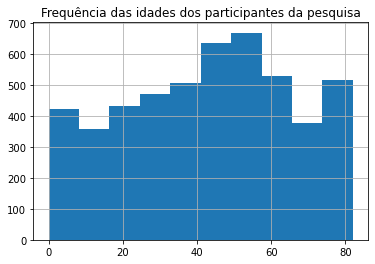

In [64]:
age.hist();
plt.title("Frequência das idades dos participantes da pesquisa");

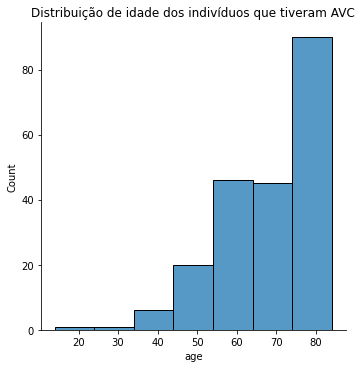

In [65]:
sns.displot(age_1,x="age",binwidth = 10)
plt.title("Distribuição de idade dos indivíduos que tiveram AVC");

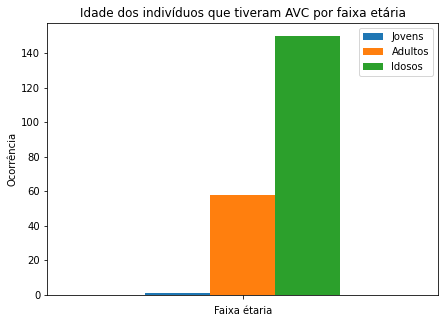

In [66]:
age_1_count = age_1.value_counts().reset_index()

age_1_count_jovens = age_1_count[age_1_count.age < 19]
age_1_count_adulto = age_1_count[age_1_count.age < 60].sum() - age_1_count_jovens
age_1_count_idoso = age_1_count[age_1_count.age > 59].sum()

age_group = pd.DataFrame([{"Jovens": age_1_count_jovens.iloc[0,1],
                           "Adultos": age_1_count_adulto.iloc[0,1],
                           "Idosos":age_1_count_idoso[0]}])
age_group = age_group.rename({0 :""}, axis='index')
age_group.plot.bar(rot=0, title='Idade dos indivíduos que tiveram AVC por faixa etária',
                   figsize=(7,5), ylabel='Ocorrência' , xlabel='Faixa étaria');

No gráfico acima verificamos as ocorrências de AVC conforme a idade, ficando nítido que, com o aumento da idade se intensifica os casos de AVC, demonstrando assim uma correlação entre idade e o risco de AVC, sendo, portanto, os idosos os mais afetados.

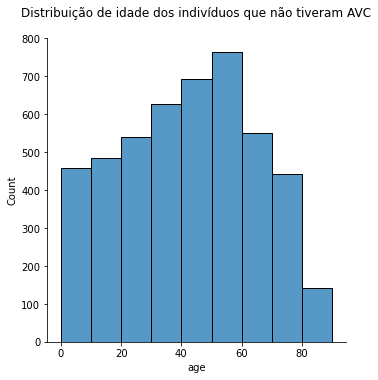

In [67]:
sns.displot(age_0,x="age",binwidth = 10);
plt.title("Distribuição de idade dos indivíduos que não tiveram AVC\n");

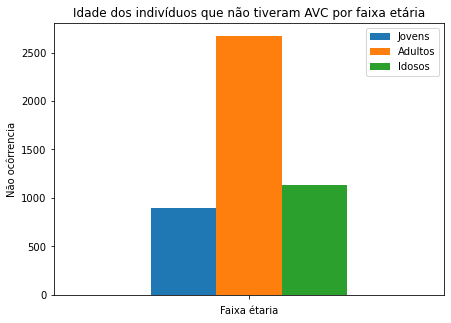

In [68]:
age_0_count = age_0.value_counts().reset_index()

age_0_count_jovens = age_0_count[age_0_count.age < 19].sum()
age_0_count_adulto = age_0_count[age_0_count.age < 60].sum() - age_0_count_jovens
age_0_count_idoso = age_0_count[age_0_count.age > 59].sum()

age_0_group = pd.DataFrame([{"Jovens": age_0_count_jovens[0], "Adultos": age_0_count_adulto[0], "Idosos": age_0_count_idoso[0]}])
age_0_group = age_0_group.rename({0 :""}, axis='index')
age_0_group.plot.bar(rot=0, title='Idade dos indivíduos que não tiveram AVC por faixa etária',
                     figsize=(7,5), ylabel='Não ocôrrencia' , xlabel='Faixa étaria');

### 2. Hipertension

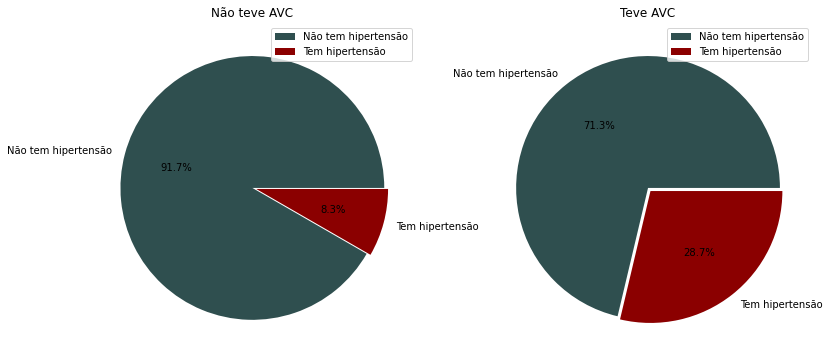

In [69]:
hypertension = pd.DataFrame({'Não teve AVC': hypertension_0, 'Teve AVC': hypertension_1})
hypertension = hypertension.rename({1: "Tem hipertensão", 0: "Não tem hipertensão"}, axis='index')
hypertension = hypertension.plot.pie(subplots= True, figsize= (13,7), explode=(0, 0.03),
                               autopct='%1.1f%%',colors= ['darkslategray','darkred'])
hypertension[0].set_ylabel("")
hypertension[1].set_ylabel("")
hypertension[0].set_title("Não teve AVC")
hypertension[1].set_title("Teve AVC");

### 3. Avg glucose level

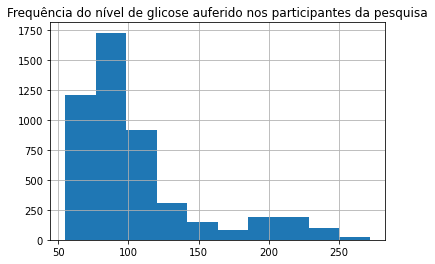

In [70]:
glicose.hist();
plt.title("Frequência do nível de glicose auferido nos participantes da pesquisa");

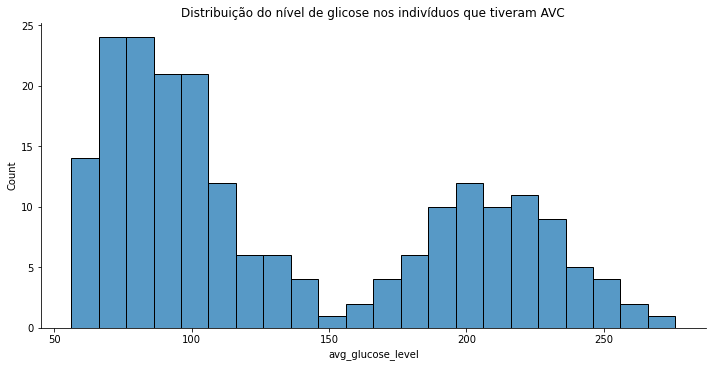

In [71]:
sns.displot(glicose_1,x="avg_glucose_level",binwidth = 10, height=5, aspect=2)
plt.title("Distribuição do nível de glicose nos indivíduos que tiveram AVC");

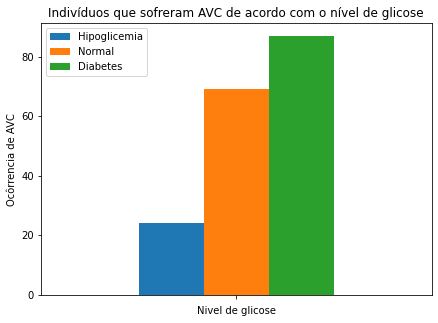

In [72]:
glicose_1_count = glicose_1.value_counts().reset_index()

glicose_1_count_baixa = glicose_1_count[glicose_1_count.avg_glucose_level < 71].sum()
glicose_1_count_normal = glicose_1_count[glicose_1_count.avg_glucose_level < 100].sum() - glicose_1_count_baixa
glicose_1_count_alta = glicose_1_count[glicose_1_count.avg_glucose_level > 125].sum()

df_glicose_1_count = pd.DataFrame([{"Hipoglicemia": glicose_1_count_baixa[0], "Normal": glicose_1_count_normal[0], "Diabetes":glicose_1_count_alta[0]}])
df_glicose_1_count = df_glicose_1_count.rename({0 :""}, axis='index')
df_glicose_1_count.plot.bar(rot=0, title='Indivíduos que sofreram AVC de acordo com o nível de glicose',
                            figsize=(7,5), ylabel='Ocôrrencia de AVC' , xlabel='Nivel de glicose');

Ao analisar os gráficos acima, nota-se uma tendência ao aumento nos casos de AVC com relação ao nivel de glicose. Pode-se inferir, pelos gráficos acima, que, indíviduos que sofrem de diabetes têm uma forte tendência a também sofrer de AVC.

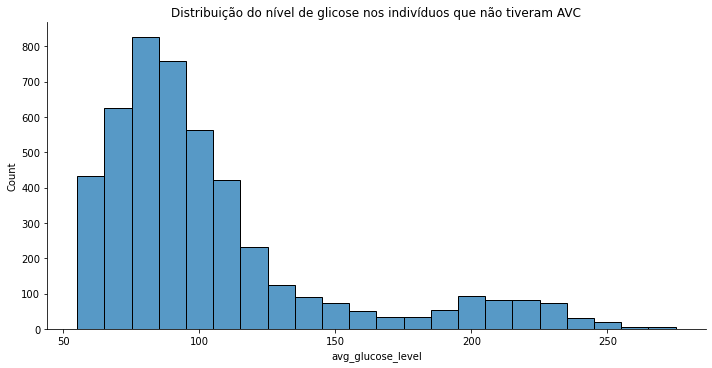

In [73]:
sns.displot(glicose_0,x="avg_glucose_level",binwidth = 10, aspect=2)
plt.title("Distribuição do nível de glicose nos indivíduos que não tiveram AVC");

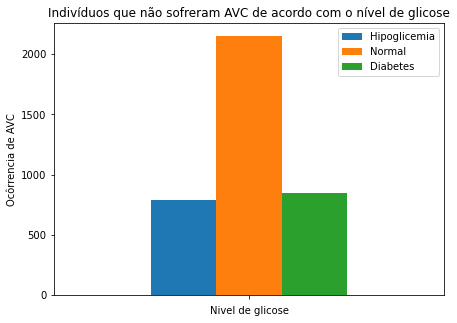

In [74]:
glicose_0_count = glicose_0.value_counts().reset_index()

glicose_0_count_baixa = glicose_0_count[glicose_0_count.avg_glucose_level < 71].sum()
glicose_0_count_normal = glicose_0_count[glicose_0_count.avg_glucose_level < 100].sum() - glicose_0_count_baixa
glicose_0_count_alta = glicose_0_count[glicose_0_count.avg_glucose_level > 125].sum()

df_glicose_0_count = pd.DataFrame([{"Hipoglicemia": glicose_0_count_baixa[0], "Normal": glicose_0_count_normal[0], "Diabetes":glicose_0_count_alta[0]}])
df_glicose_0_count = df_glicose_0_count.rename({0 :""}, axis='index')
df_glicose_0_count.plot.bar(rot=0, title='Indivíduos que não sofreram AVC de acordo com o nível de glicose', figsize=(7,5), ylabel='Ocôrrencia de AVC' , xlabel='Nivel de glicose');

### 4. Smoking status

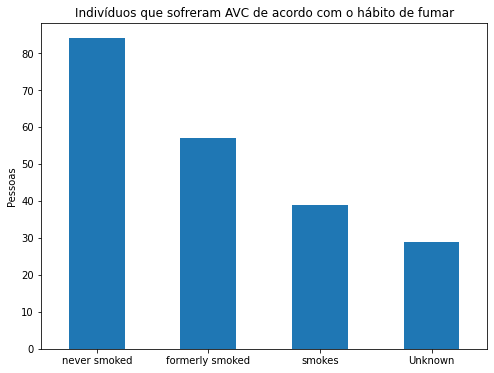

In [75]:
smoke_status_1.plot.bar(rot=0, ylabel="Pessoas", title="Indivíduos que sofreram AVC de acordo com o hábito de fumar",
                      figsize=(8,6));

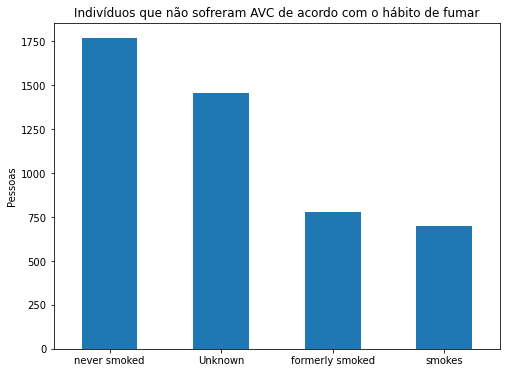

In [76]:
smoke_status_0.plot.bar(rot=0, ylabel ="Pessoas",title = "Indivíduos que não sofreram AVC de acordo com o hábito de fumar",
                      figsize=(8,6));

Dados demonstram que pessoas que fumam tem mais chances de ter AVC do que as que não tem esse hábito.

### 5. Residence type

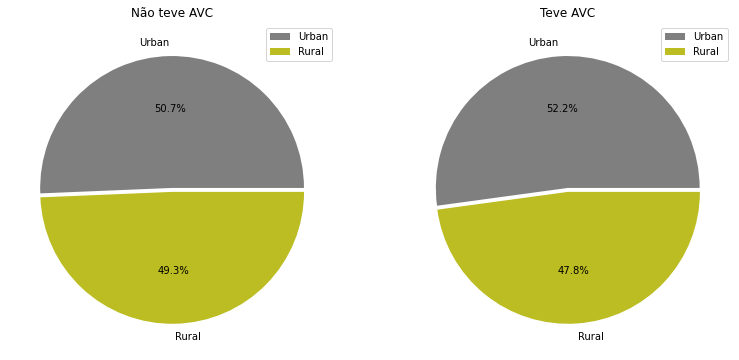

In [77]:
# Pessoas que moram na cidade tem uma porcentagem maior de ter avc

residence = pd.DataFrame({'Não teve AVC': residence_0, 'Teve AVC': residence_1})
residence = residence.plot.pie(subplots= True, figsize= (13,7), explode=(0, 0.03),
                               autopct='%1.1f%%',colors= ['tab:gray','tab:olive'])

residence[0].set_ylabel("")
residence[1].set_ylabel("")
residence[0].set_title("Não teve AVC")
residence[1].set_title("Teve AVC");

### 6. BMI (Body mass index)

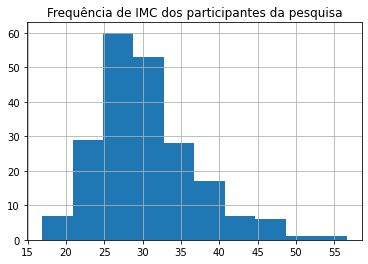

In [78]:
bmi_1.hist()
plt.title("Frequência de IMC dos participantes da pesquisa");

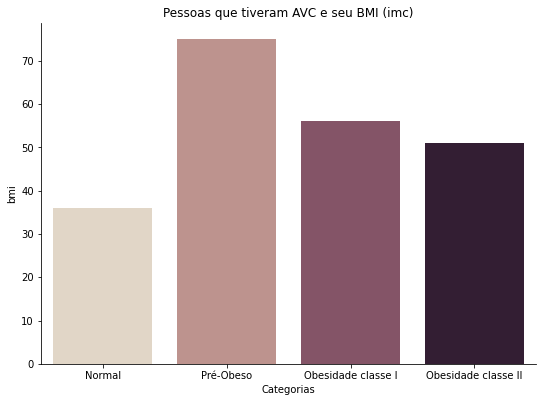

In [79]:
bmi_group = bmi_1["bmi"].value_counts()

bmi_group_1 = bmi_group[bmi_group.index < 25].sum()
bmi_group_2 = bmi_group[bmi_group.index < 30].sum() - bmi_group_1
bmi_group_3 = bmi_group[bmi_group.index < 35].sum() -  (bmi_group_2 + bmi_group_1)
bmi_group_4 = bmi_group[bmi_group.index > 34].sum()

bmi_group_df = pd.DataFrame([{"Normal": bmi_group_1, "Pré-Obeso": bmi_group_2, 
                          "Obesidade classe I": bmi_group_3, "Obesidade classe II": bmi_group_4}])
bmi_group_df = bmi_group_df.rename({0 :"BMI"}, axis='columns')
bmi_group_df = sns.catplot(data=bmi_group_df,palette="ch:.25", kind="bar", height=5.27, aspect=11.7/8.27)
bmi_group_df.set(xlabel='Categorias', ylabel='bmi', title='Pessoas que tiveram AVC e seu BMI (imc)');

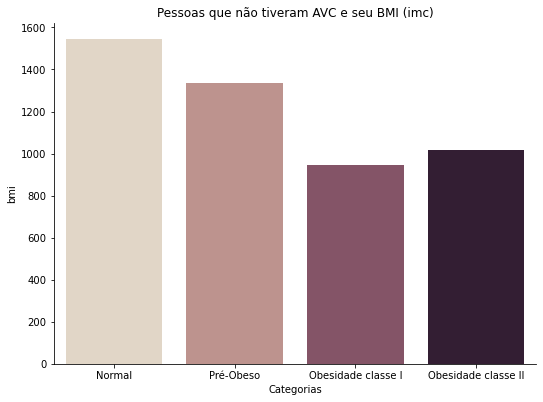

In [80]:
bmi_group_0 = bmi_0["bmi"].value_counts().to_frame()

bmi_group_0 = bmi_group_0.dropna()
bmi1 = bmi_group_0[bmi_group_0.index < 25].sum()
bmi2 = bmi_group_0[bmi_group_0.index < 30].sum() - bmi1
bmi3 = bmi_group_0[bmi_group_0.index < 35].sum() -  (bmi2 + bmi1)
bmi4 = bmi_group_0[bmi_group_0.index > 34].sum()

df_bmi_group_0 = pd.DataFrame([{"Normal": bmi1[0], "Pré-Obeso": bmi2[0],
                          "Obesidade classe I":bmi3[0], "Obesidade classe II": bmi4[0]}])

ax = sns.catplot(data=df_bmi_group_0,palette="ch:.25", kind="bar", height=5.27, aspect=11.7/8.27)
ax.set(xlabel='Categorias', ylabel='bmi', title='Pessoas que não tiveram AVC e seu BMI (imc)');

### 7. Heart disease (Doença cardíaca)

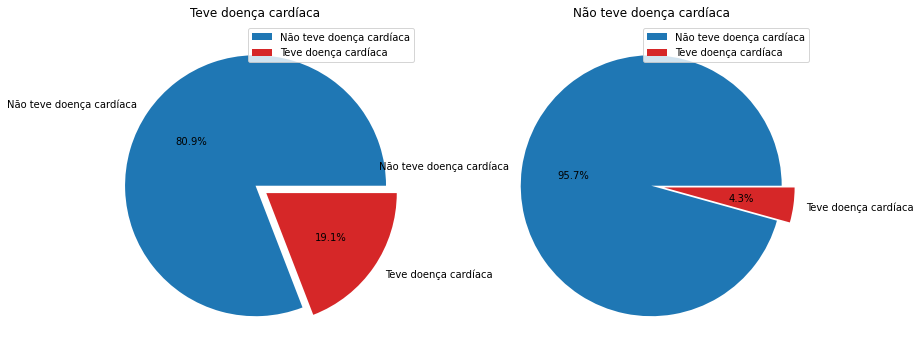

In [81]:
# Observamos que existe um número elevado de pessoas sem problemas do coração, o que prejudica a análise
# Trabalhemos, portanto com percentual

ax_heart = heart.plot.pie(subplots=True, figsize= (13,6), ylabel='', 
                          explode=(0, 0.1), autopct='%1.1f%%', colors=['tab:blue','tab:red']);

ax_heart[0].set_title("Teve doença cardíaca")
ax_heart[1].set_title("Não teve doença cardíaca");

### 8. Gender (gênero)

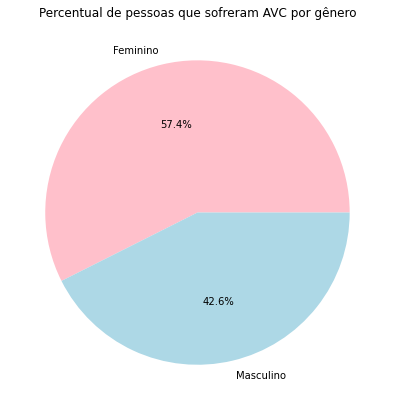

In [82]:
gender["gender_perc_1"].dropna().plot.pie(title="Percentual de pessoas que sofreram AVC por gênero",
                                 ylabel='', colors=['pink', 'lightblue'], autopct='%1.1f%%',
                                 labels=["Feminino", "Masculino", ""], figsize=(13,7));

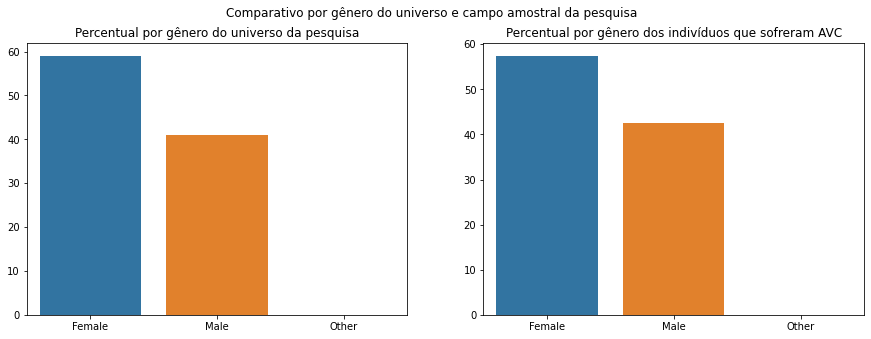

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparativo por gênero do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=gender.index, y='gender_perc', data=gender)
axes[0].set_title('Percentual por gênero do universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=gender.index, y='gender_perc_1', data=gender)
axes[1].set_title('Percentual por gênero dos indivíduos que sofreram AVC')
axes[1].set_ylabel('');

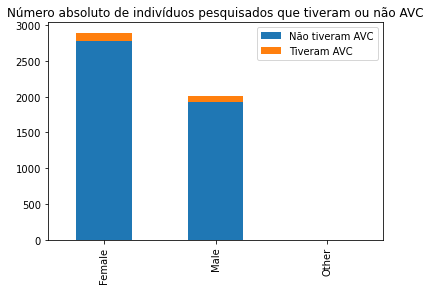

In [84]:
ax = gender[['gender_0', 'gender_1']].plot.bar(stacked=True)

ax.legend(["Não tiveram AVC", "Tiveram AVC"])
plt.title("Número absoluto de indivíduos pesquisados que tiveram ou não AVC");

### 9. Ever married (Estado civil)

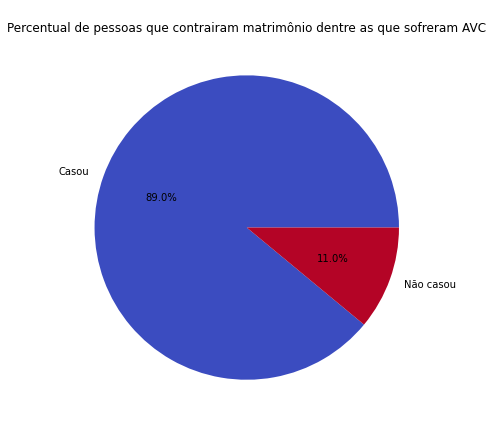

In [85]:
married["married_perc_1"].plot.pie(title="\nPercentual de pessoas que contrairam matrimônio dentre as que sofreram AVC",
                                   ylabel='', colormap="coolwarm", figsize=(10,7),autopct='%1.1f%%');

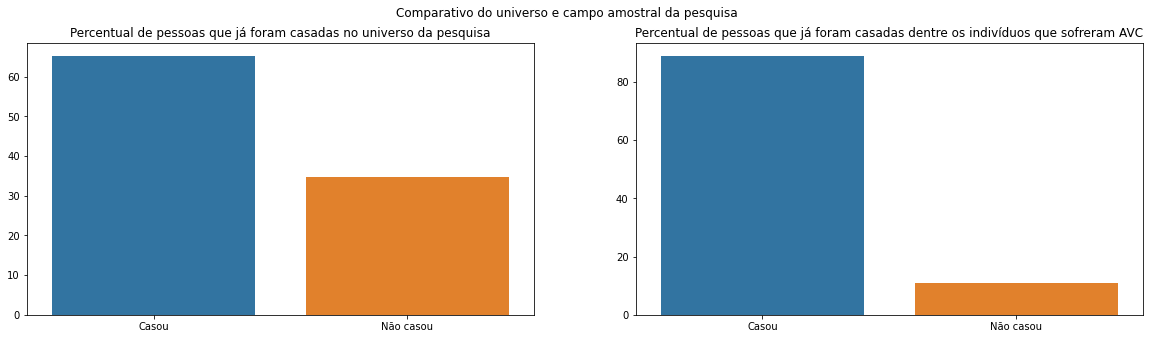

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Comparativo do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=married.index, y='married_perc', data=married)
axes[0].set_title('Percentual de pessoas que já foram casadas no universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=married.index, y='married_perc_1', data=married)
axes[1].set_title('Percentual de pessoas que já foram casadas dentre os indivíduos que sofreram AVC')
axes[1].set_ylabel('');

### 10. Work type(Tipo de trabalho)

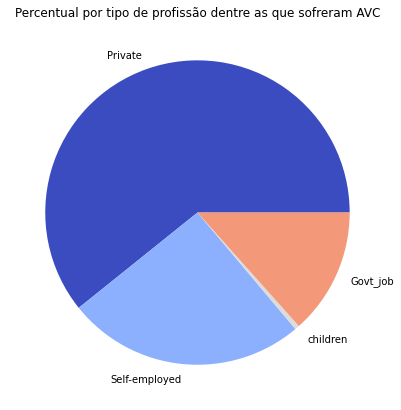

In [87]:
work["work_perc_1"].plot.pie(title="Percentual por tipo de profissão dentre as que sofreram AVC", ylabel='',
                             colormap="coolwarm", figsize=(10,7));

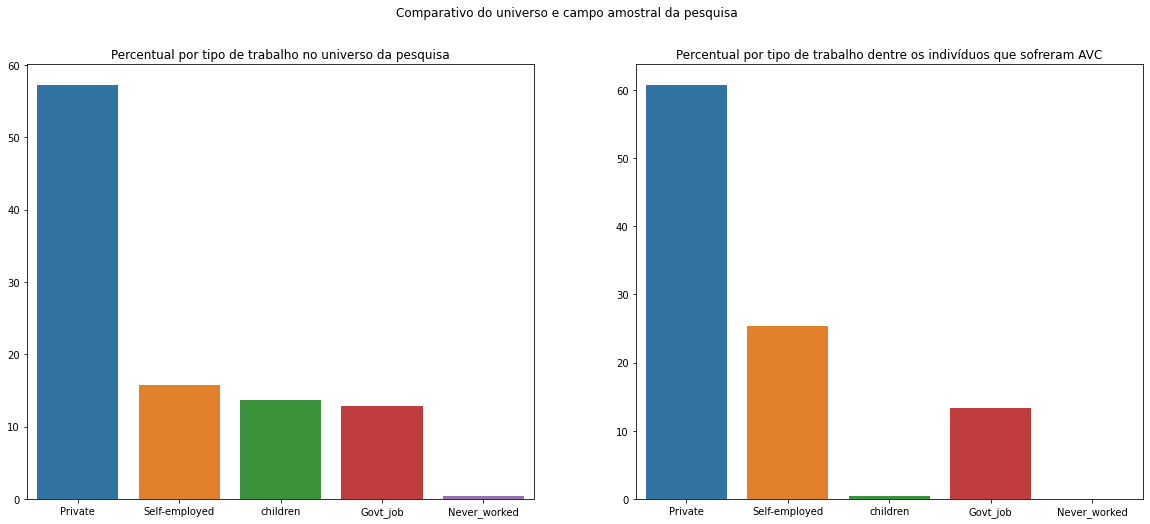

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparativo do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=work.index, y='work_perc', data=work)
axes[0].set_title('Percentual por tipo de trabalho no universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=work.index, y='work_perc_1', data=work)
axes[1].set_title('Percentual por tipo de trabalho dentre os indivíduos que sofreram AVC')
axes[1].set_ylabel('');

## Agrupamentos

Esta seção não possui o intúito de responder nenhuma pergunta da pesquisa, tentaremos, contudo, reconhecer agrupamentos de indivíduos presentes no dataset trabalho.

In [89]:
# Função para plotar gráficos de dispersão de acordo com os grupos formados

def group_Kmeans(df,X,Y,n):
    group = df[[X,Y]]
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(group)
    sns.scatterplot(data=group, x=X, y=Y, hue=kmeans.labels_, palette="muted")

Substituindo os valores de string para numéricos com intuito de facilitar as operações realizadas a seguir.

In [90]:
db["gender"] = db["gender"].replace(['Female', 'Male', 'Other'], [0, 1,2]);

In [91]:
db['work_type'] = db['work_type'].replace(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
                                                    [0, 1, 2, 3, 4])

In [92]:
db['Residence_type'] = db['Residence_type'].replace(['Urban', 'Rural'], [0, 1])

In [93]:
db["smoking_status"] = db["smoking_status"].replace(['never smoked', 'Unknown', 'formerly smoked', 'smokes'],
                                                            [0, 1, 2, 3])

In [94]:
# Atualizando os valores das variáveis abaixo
stroke_1 = db[db.stroke == 1]
stroke_0 = db[db.stroke == 0]
db.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67,0,1,1,0,0,228.69,36.6,2,1
2,31112,1,80,0,1,1,0,1,105.92,32.5,0,1
3,60182,0,49,0,0,1,0,0,171.23,34.4,3,1
4,1665,0,79,1,0,1,1,1,174.12,24.0,0,1
5,56669,1,81,0,0,1,0,0,186.21,29.0,2,1


### Idade

Agrupando os dados apartir dos atributos **age(idade)** e **bmi(imc)**:

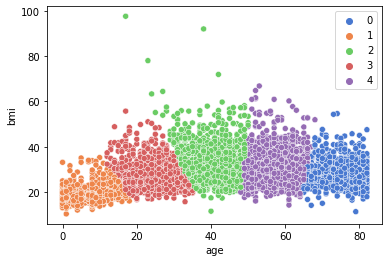

In [95]:
# Com relação a todo o database

group_Kmeans(db,"age", "bmi",5)

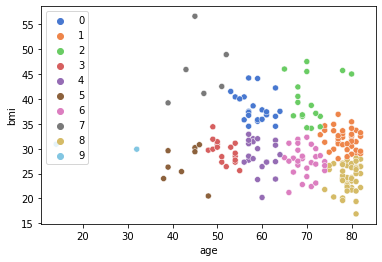

In [96]:
# Com relação aos indivíduos que tiveram AVC

group_Kmeans(stroke_1,"age", "bmi", 10)

Aumento do BMI conforme a idade, chengando ao ápice por volta do 40 anos e reduzindo novamente.

Agrupando os dados apartir dos atributos **age (idade)** e **avg_glucose_level (nível de glicose)**:

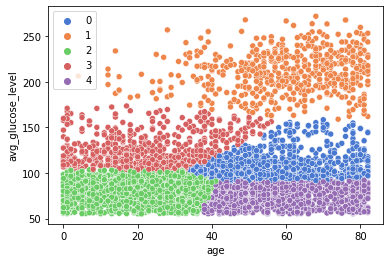

In [97]:
# Com relação a todo o database

group_Kmeans(db,"age", "avg_glucose_level",5)

Foram formados 5 grupos: jovens e adultos(0 a 40 anos) com glicose baixa, jovens e adultos(0 a 40 anos) com glicose alta, indivíduos com glicose normal, adultos e idosos(40 a 80 anos) com glicose baixa e adultos e idosos(40 a 80 anos) com glicose alta.

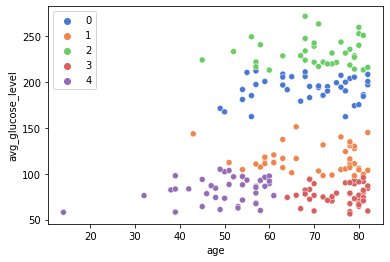

In [98]:
# Com relação aos indivíduos que tiveram AVC

group_Kmeans(stroke_1,"age", "avg_glucose_level",5)

Aumento das ocorrências de desregularidade da glicose conforme a idade aumenta. 

Agrupando os dados com base nos atributos **hypertension(hipertensão)** e **age(idade)**

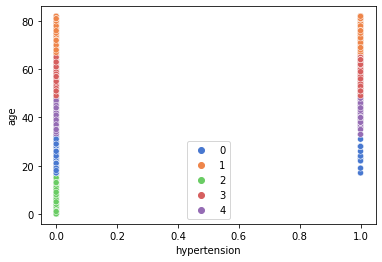

In [99]:
# Com relação a todo o database
group_Kmeans(db,"hypertension", "age",5)

Legenda:
- 0.0 = Não hipertenso

- 1.0 = Hipertenso

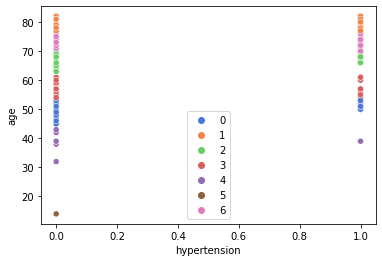

In [100]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"hypertension", "age",7)

Legenda:
- 0.0 = Não hipertenso

- 1.0 = Hipertenso

A primeira ocorrência de hipertensão dentre os indivíduos que tiveram AVC se dá aos 37 anos.

Agrupando os dados com base nos atributos **heart_disease(doenças cardíacas)** e **age(idade)**

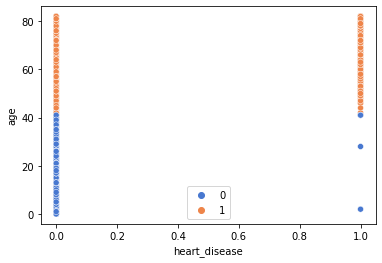

In [101]:
# Com relação a todo o database
group_Kmeans(db,"heart_disease", "age",2)

Legenda:
- 0.0 = Não cardíaco

- 1.0 = Cardíaco

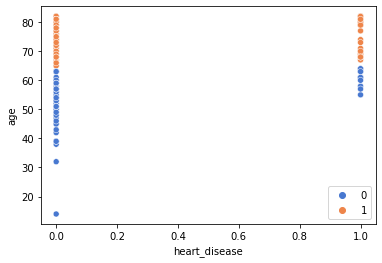

In [102]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"heart_disease", "age",2)

Legenda:
- 0.0 = Não cardíaco

- 1.0 = Cardíaco

A primeira ocorrência de doenças cardíacas dentre os indivíduos que tiveram AVC se dá, aproximadamente, aos 55 anos.

Agrupando os dados com base nos atributos **gender(gênero)** e **age(idade)**

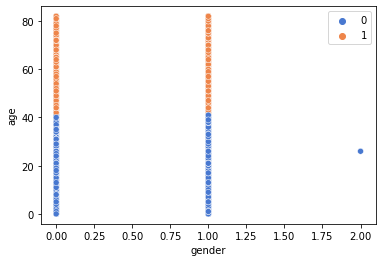

In [103]:
# Com relação a todo o database
group_Kmeans(db,"gender", "age",2)

Legenda:
- 0.00 = Mulher

- 1.00 = Homem

- 2.00 = Outros

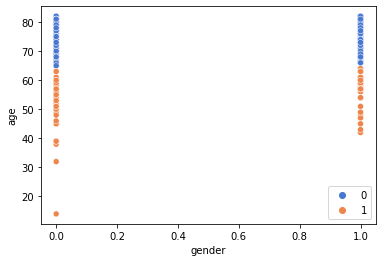

In [104]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"gender", "age",2)

Legenda:
- 0.00 = Mulher

- 1.00 = Homem

Bem distribuído.

Agrupando os dados com base nos atributos **ever_married(estado civil)** e **age(idade)**

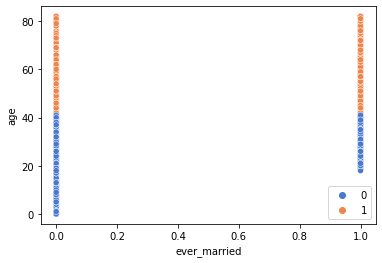

In [105]:
# Com relação a todo o database
group_Kmeans(db,"ever_married", "age",2)

Legenda:
- 0.0 = Não é casado

- 1.0 = Casado

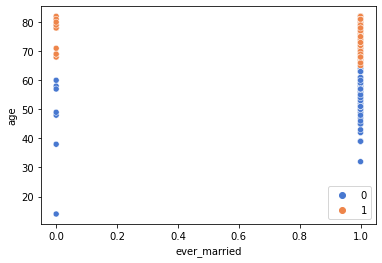

In [106]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"ever_married", "age",2)

Legenda:
- 0.0 = Não é casado

- 1.0 = Casado

Agrupando os dados com base nos atributos **work_type(tipo de trabalho)** e **age(idade)**

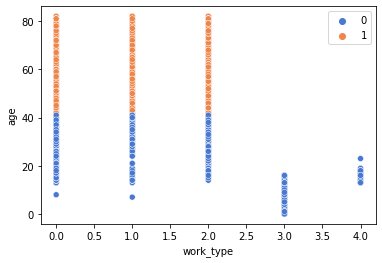

In [107]:
# Com relação a todo o database
group_Kmeans(db,"work_type", "age",2)

Legenda:
- 0.0 = Private

- 1.0 = Self-employed

- 2.0 = Govt_job

- 3.0 = children

- 4.0 = Never_worked

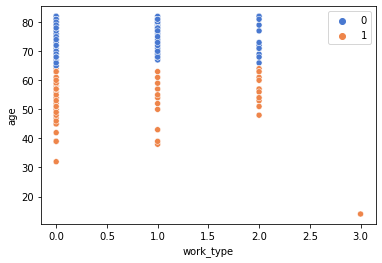

In [108]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"work_type", "age",2)

Legenda:
- 0.0 = Private

- 1.0 = Self-employed

- 2.0 = Govt_job

- 3.0 = children

- 4.0 = Never_worked

Distribuição muito equilibrada, com exceção dos indivíduos aproximadamente abaixo dos 25 anos que nunca trabalharam.

Obs.: Números de AVC's é maior em trabalhos privados e independentes quando comparados aos servidores públicos.

Agrupando os dados com base nos atributos **Residence_type(tipo de moradia)** e **age(idade)**

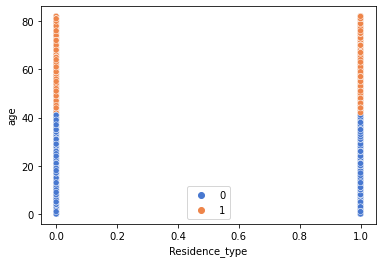

In [109]:
# Com relação a todo o database
group_Kmeans(db,"Residence_type", "age",2)

Legenda:
- 0.0 = Urbano

- 1.0 = Rural

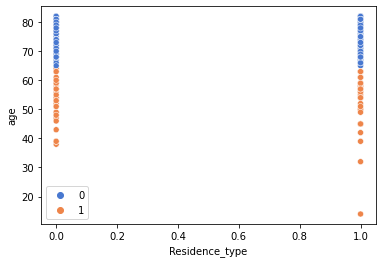

In [110]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"Residence_type", "age",2)

Legenda:
- 0.0 = Urbano

- 1.0 = Rural

Bem destribuido.

Agrupando os dados com base nos atributos **smoking_status(hábito de fumar)** e **age(idade)**

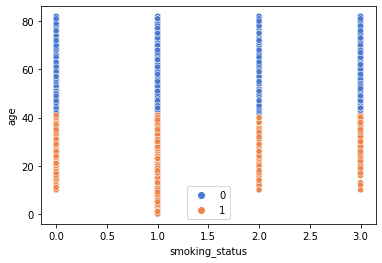

In [111]:
# Com relação a todo o database
group_Kmeans(db,"smoking_status", "age",2)

Legenda:
- 0.0 = never smoked

- 1.0 = Unknown

- 2.0 = formerly smoked

- 3.0 = smokes

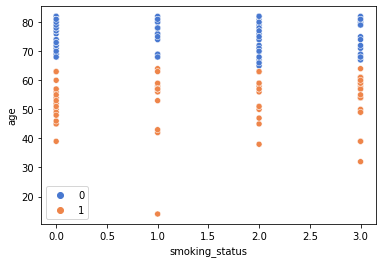

In [112]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"smoking_status", "age",2)

Legenda:
- 0.0 = never smoked

- 1.0 = Unknown

- 2.0 = formerly smoked

- 3.0 = smokes

Antes dos 10 anos a maioria se encaixa no status "Unknown", provavelmente em decorrência de restrições baseadas na ética da pesquisa.Observa-se ainda que, nos maiores de 10 anos os dados estão bem distribuidos.

### Glicose

Agrupando os dados com base nos atributos **bmi (imc)** e **avg_glucose_level (nível de glicose)**:

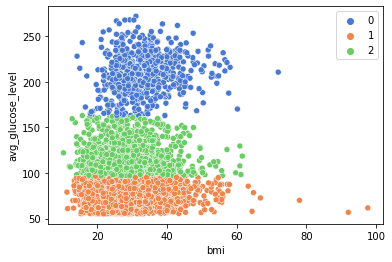

In [113]:
# Com relação a todo o database

group_Kmeans(db,"bmi", "avg_glucose_level",3)

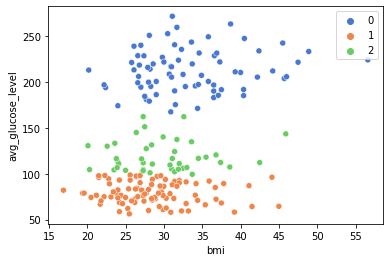

In [114]:
# Com relação aos indíviduos que tiveram AVC

group_Kmeans(stroke_1,"bmi", "avg_glucose_level",3)

Com o aumento do BMI nota-se uma maior ocorrência de glicose alta.

Agrupando os dados com base nos atributos **hypertension(hipertensão)** e **avg_glucose_level (nível de glicose)**

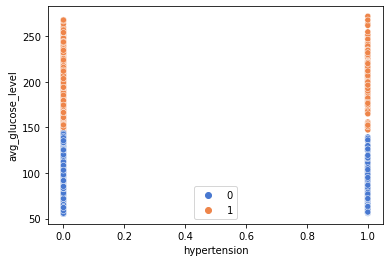

In [115]:
# Com relação a todo o database
group_Kmeans(db,"hypertension", "avg_glucose_level",2)

Legenda:
- 0.0 = Não hipertenso

- 1.0 = Hipertenso

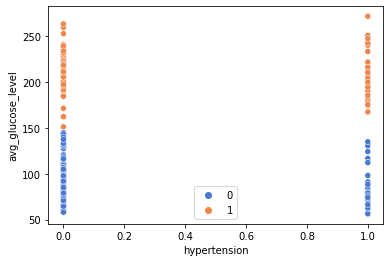

In [116]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"hypertension", "avg_glucose_level",2)

Legenda:
- 0.0 = Não hipertenso

- 1.0 = Hipertenso

Agrupando os dados com base nos atributos **gender(gênero)** e **avg_glucose_level (nível de glicose)**

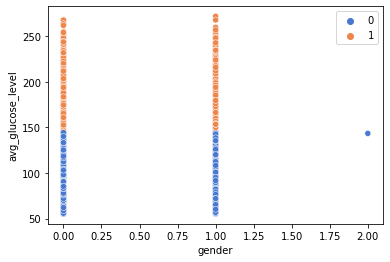

In [117]:
# Com relação a todo o database
group_Kmeans(db,"gender", "avg_glucose_level",2)

Legenda:
- 0.00 = Mulher

- 1.00 = Homem

- 2.00 = Outros

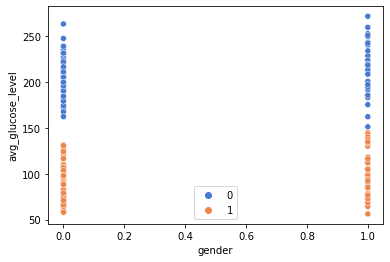

In [118]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"gender", "avg_glucose_level",2)

Legenda:
- 0.00 = Mulher

- 1.00 = Homem

Agrupando os dados com base nos atributos **heart_disease(doenças cardíacas)** e **avg_glucose_level (nível de glicose)**

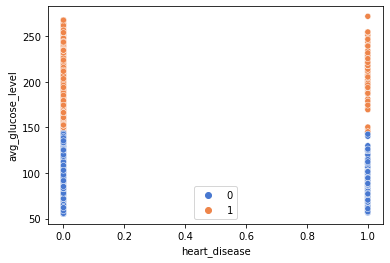

In [119]:
# Com relação a todo o database
group_Kmeans(db,"heart_disease", "avg_glucose_level",2)

Legenda:
- 0.0 = Não cardíaco

- 1.0 = Cardíaco

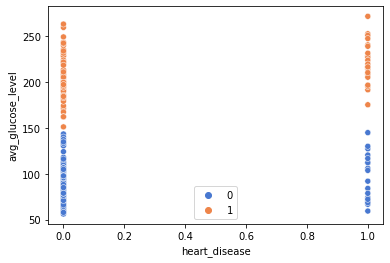

In [120]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"heart_disease", "avg_glucose_level",2)

Legenda:
- 0.0 = Não cardíaco

- 1.0 = Cardíaco

Agrupando os dados com base nos atributos **ever_married(estado civil)** e **avg_glucose_level (nível de glicose)**

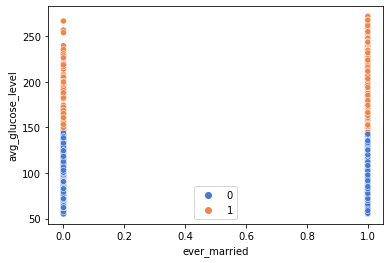

In [121]:
# Com relação a todo o database
group_Kmeans(db,"ever_married", "avg_glucose_level",2)

Legenda:
- 0.0 = Não é casado

- 1.0 = Casado

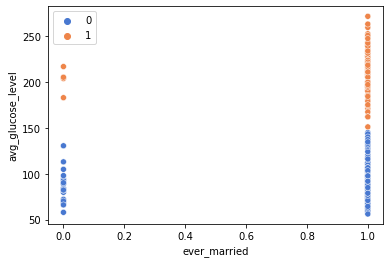

In [122]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"ever_married", "avg_glucose_level",2)

Legenda:
- 0.0 = Não é casado

- 1.0 = Casado

Não casados tem niveis de glicose bem mais baixos e controlados do que casados.

Agrupando os dados com base nos atributos **work_type(tipo de trabalho)** e **avg_glucose_level (nível de glicose)**

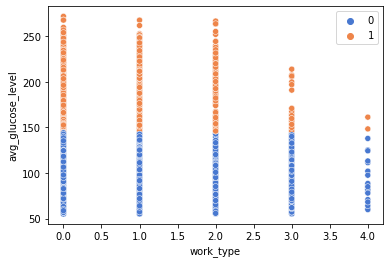

In [123]:
# Com relação a todo o database
group_Kmeans(db,"work_type", "avg_glucose_level",2)

Legenda:
- 0.0 = Private

- 1.0 = Self-employed

- 2.0 = Govt_job

- 3.0 = children

- 4.0 = Never_worked

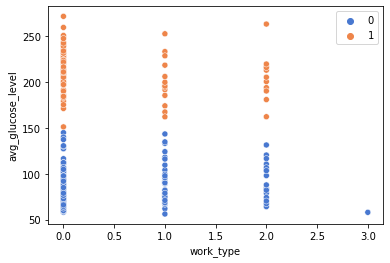

In [124]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"work_type", "avg_glucose_level",2)

Legenda:
- 0.0 = Private

- 1.0 = Self-employed

- 2.0 = Govt_job

- 3.0 = children

- 4.0 = Never_worked

Os níveis de glicose vairiam de acordo com cada tipo de trabalho.

Agrupando os dados com base nos atributos **Residence_type(tipo de moradia)** e **avg_glucose_level (nível de glicose)**

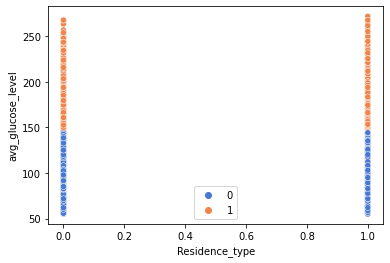

In [125]:
# Com relação a todo o database
group_Kmeans(db,"Residence_type", "avg_glucose_level",2)

Legenda:
- 0.0 = Urbano

- 1.0 = Rural

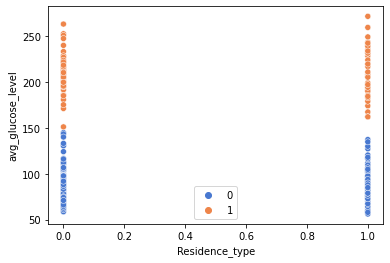

In [126]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"Residence_type", "avg_glucose_level",2)

Legenda:
- 0.0 = Urbano

- 1.0 = Rural

Agrupando os dados com base nos atributos **smoking_status(hábito de fumar)** e **avg_glucose_level (nível de glicose)**

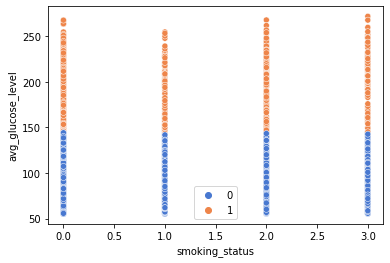

In [127]:
# Com relação a todo o database
group_Kmeans(db,"smoking_status", "avg_glucose_level",2)

Legenda:
- 0.0 = never smoked

- 1.0 = Unknown

- 2.0 = formerly smoked

- 3.0 = smokes

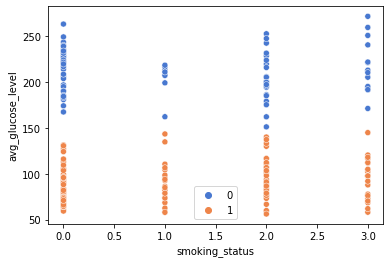

In [128]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"smoking_status", "avg_glucose_level",2)

Legenda:
- 0.0 = never smoked

- 1.0 = Unknown

- 2.0 = formerly smoked

- 3.0 = smokes

### BMI

Agrupando os dados com base nos atributos **bmi (imc)** e **smoking_status(hábito de fumar)**:

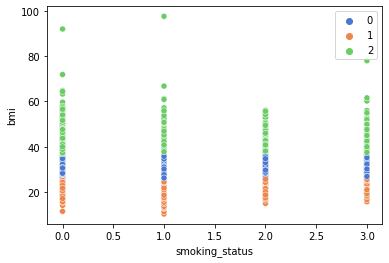

In [129]:
# Com relação a todo o database
group_Kmeans(db,"smoking_status", "bmi",3)

Legenda:
- 0.0 = never smoked

- 1.0 = Unknown

- 2.0 = formerly smoked

- 3.0 = smokes

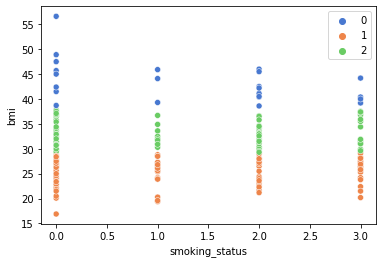

In [130]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"smoking_status", "bmi",3)

Legenda:
- 0.0 = never smoked

- 1.0 = Unknown

- 2.0 = formerly smoked

- 3.0 = smokes

Agrupando os dados com base nos atributos **bmi (imc)** e **gender(gênero)**:

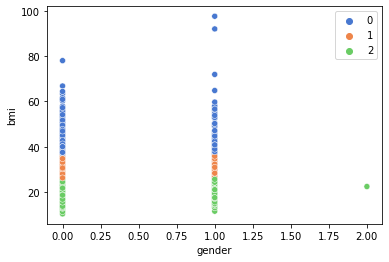

In [131]:
# Com relação a todo o database
group_Kmeans(db,"gender", "bmi",3)

Legenda:
- 0.00 = Mulher

- 1.00 = Homem

- 2.00 = Outros

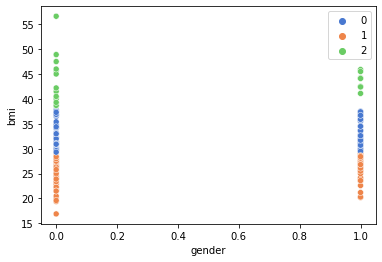

In [132]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"gender", "bmi",3)

Legenda:
- 0.00 = Mulher

- 1.00 = Homem

Agrupando os dados com base nos atributos **bmi (imc)** e **heart_disease(doenças cardíacas)**:

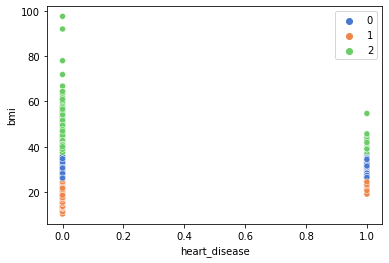

In [133]:
# Com relação a todo o database
group_Kmeans(db,"heart_disease", "bmi",3)

Legenda:
- 0.0 = Não cardíaco

- 1.0 = Cardíaco

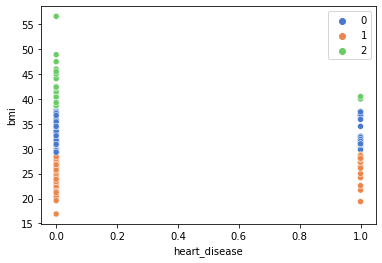

In [134]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"heart_disease", "bmi",3)

Legenda:
- 0.0 = Não cardíaco

- 1.0 = Cardíaco

Variação de IMC de quem tem doenças cardíacas é menor do que nos indivíduos que não tem.

Agrupando os dados com base nos atributos **bmi (imc)** e **hypertension(hipertensão)**:

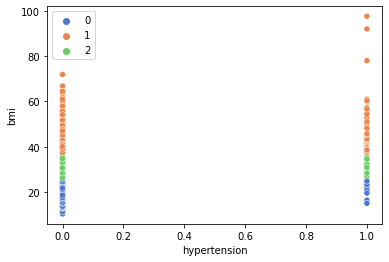

In [135]:
# Com relação a todo o database
group_Kmeans(db,"hypertension", "bmi",3)

Legenda:
- 0.0 = Não hipertenso

- 1.0 = Hipertenso

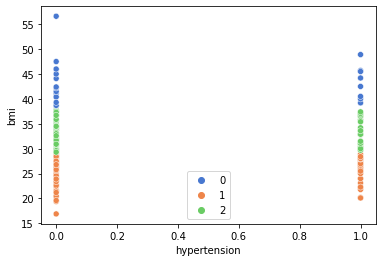

In [136]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"hypertension", "bmi",3)

Legenda:
- 0.0 = Não hipertenso

- 1.0 = Hipertenso

Agrupando os dados com base nos atributos **bmi (imc)** e **work_type(tipo de trabalho)**:

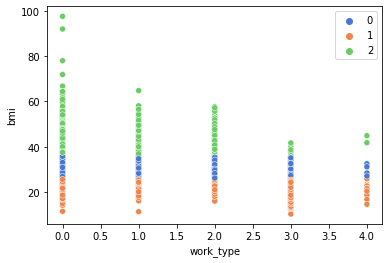

In [137]:
# Com relação a todo o database
group_Kmeans(db,"work_type", "bmi",3)

Legenda:
- 0.0 = Private

- 1.0 = Self-employed

- 2.0 = Govt_job

- 3.0 = children

- 4.0 = Never_worked

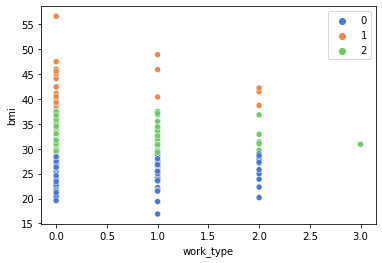

In [138]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"work_type", "bmi",3)

Legenda:
- 0.0 = Private

- 1.0 = Self-employed

- 2.0 = Govt_job

- 3.0 = children

- 4.0 = Never_worked

O IMC varia conforme o tipo de trabalho.

Agrupando os dados com base nos atributos **bmi (imc)** e **ever_married(estado civil)**:

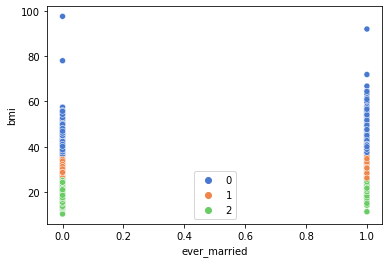

In [139]:
# Com relação a todo o database
group_Kmeans(db,"ever_married", "bmi",3)

Legenda:
- 0.0 = Não é casado

- 1.0 = Casado

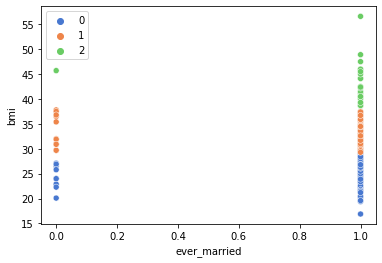

In [140]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"ever_married", "bmi",3)

Legenda:
- 0.0 = Não é casado

- 1.0 = Casado

Indivíduos solteiros tem seu IMC em média menor que o dos casados.

Agrupando os dados com base nos atributos **bmi (imc)** e **Residence_type(tipo de residência)**:

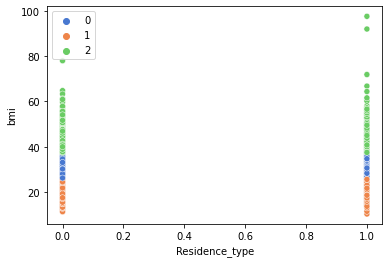

In [141]:
# Com relação a todo o database
group_Kmeans(db,"Residence_type", "bmi",3)

Legenda:
- 0.0 = Urbano

- 1.0 = Rural

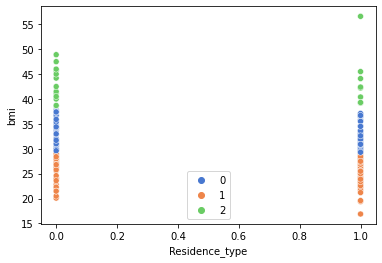

In [142]:
# Com relação aos indíviduos que tiveram AVC
group_Kmeans(stroke_1,"Residence_type", "bmi",3)

Legenda:
- 0.0 = Urbano

- 1.0 = Rural

## Montagem de perfis

***É possível montar perfis de pessoas que tiveram AVC com base nos dados analisados e nos agrupamentos anteriormente realizados?***

### Jovens

Entre 0 e 10 anos :

    BMI :                Abaixo de 40
    Glicose:             Entre 50 e 140
    Hipertensão:         Não
    Doenças Cardíacas:   Não
    Gênero:              Ambos os gêneros
    Estado civil:        Não casado
    Tipo de trabalho:    crianças(nunca trabalharam)
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não sabem
    
    Baixissímas ocorrências de AVC 
    
    
Entre 10 e 20 anos :

    BMI :                Abaixo de 50
    Glicose:             Entre 55 e 150
    Hipertensão:         Não (Pouquíssimas ocorrências)
    Doenças Cardíacas:   Não (Pouquíssimas ocorrências)
    Gênero:              Ambos os gêneros
    Estado civil:        Não casado (Maioria)
    Tipo de trabalho:    nunca trabalharam (Algumas ocorrências de outros tipos)
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não há como estipular
    
    Baixissímas ocorrências de AVC 

### Adultos

Entre 20 e 30 anos :

    BMI :                Entre 15 e 60
    Glicose:             Entre 55 e 160
    Hipertensão:         Não (poucas ocerrências)
    Doenças Cardíacas:   Não (Poquíssimas ocerrências)
    Gênero:              Ambos os gêneros
    Estado civil:        casado (muitos casos)
    Tipo de trabalho:    Não há como estipular
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não há como estipular
    
    Baixissímas ocorrências de AVC  

Entre 30 e 40 anos :

    BMI :                Aproximadamente entre 20 e 60 
    Glicose:             Entre 55 e 200
    Hipertensão:         Não (algumas ocorrências)
    Doenças Cardíacas:   Não (Pouquíssimas ocorrências)
    Gênero:              Ambos os gêneros
    Estado civil:        casado (muitos casos)
    Tipo de trabalho:    Não há como estipular
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não há como estipular
    
    Baixas ocorrências de AVC  

Entre 40 e 50 anos :
    
    BMI :                Aproximadamente entre 20 e 60 
    Glicose:             Entre 55 e 220
    Hipertensão:         Não (algumas ocorrências)
    Doenças Cardíacas:   Não (algumas ocorrências)
    Gênero:              Ambos os gêneros
    Estado civil:        casado (muitos casos)
    Tipo de trabalho:    Não há como estipular
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não há como estipular
    
    algumas ocorrências de AVC 

Entre 50 e 60 anos :

    BMI :                Abaixo de 55
    Glicose:             Entre 55 e 230
    Hipertensão:         Sim (muitas ocorrências)
    Doenças Cardíacas:   Sim (muitas ocorrências)
    Gênero:              Ambos os gêneros
    Estado civil:        casado (muitos casos)
    Tipo de trabalho:    Não há como estipular
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não há como estipular
    
    Risco considerável de AVC  


### Idosos

Entre 60 e 70 anos :

    BMI :                Abaixo de 55
    Glicose:             Entre 55 e 240
    Hipertensão:         Sim (muitas ocorrências)
    Doenças Cardíacas:   Sim (muitas ocorrências)
    Gênero:              Ambos os gêneros
    Estado civil:        casado (muitos casos)
    Tipo de trabalho:    Não há como estipular
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não há como estipular
  
    Muitas ocorrências de AVC

Superior a 70 anos :

    BMI :                Abaixo de 50
    Glicose:             Entre 55 e 250
    Hipertensão:         Sim (muitas ocorrências)
    Doenças Cardíacas:   Sim (muitas ocorrências)
    Gênero:              Ambos os gêneros
    Estado civil:        casado (muitos casos)
    Tipo de trabalho:    Não há como estipular
    Tipo de residencia:  Ambos os tipos(urbano e rural)
    Hábito de fumar:     Não há como estipular
    
    Muitissímas ocorrências de AVC 

### Perfis complementares

Tipo de trabalho:

Indivíduos que o tipo de trabalho é privado tem uma maior chance de terem AVC mais cedo que os demais.

Indivíduos que o tipo de trabalho é privado tem níveis de glicose mais elevados do que os demais.

Indivíduos que o tipo de trabalho é público (govt_job) tem menos chance de terem AVC mais cedo que os demais.

Indivíduos que o tipo de trabalho é público (govt_job) tem níveis de glicose mais baixos que os demais.


Estado civil:

Indivíduos com mais de 30 anos tem mais chance de serem casados do que pessoas com menos idade.

Indivíduos não casados tem niveis de glicose bem mais baixos e controlados do que o dos casados.

Indivíduos solteiros tem seus IMC's em média menor do que o dos casados.


Hábito de fumar:

O hábito de fumar torna a ocorrência de AVC mais precoce.


Tipo de moradia:

Indivíduos que moram na área urbana tem uma maior chance de terem AVC mais cedo.


BMI:

Indivíduos com maior IMC tendem a ter maiores taxas de glicose.

Indivíduos que o tipo de trabalho é privado tem em média um IMC maior que os demais.

Indivíduos que nunca trabalharam e crianças tem em média um IMC menor que os demais.

Indivíduos que tem doenças cardíacas, em média, tem IMC menor que os indivíduos que não tem.

## Aplicação de Modelos de Machine Learning

**É viável a implementação de um modelo de aprendizagem de máquina para a predição do AVC? Qual o grau de acurácia?**

### 1. Pré-processamento do Dataset

In [143]:
pred_db = pred_db.sample(frac=1)
pred_db.drop('id', axis=1, inplace=True)
pred_db

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
710,Female,79,0,0,1,Self-employed,Rural,131.85,25.9,Unknown,0
837,Female,39,0,0,0,Govt_job,Urban,79.44,22.7,never smoked,0
102,Female,74,0,0,1,Private,Rural,231.61,34.6,formerly smoked,1
749,Male,55,0,0,1,Govt_job,Rural,65.12,30.0,never smoked,0
684,Female,1,0,0,0,children,Urban,130.61,14.4,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
87,Female,70,0,1,1,Private,Rural,59.35,32.3,formerly smoked,1
721,Female,28,0,0,0,Private,Rural,84.59,23.5,Unknown,0
159,Female,81,1,0,1,Self-employed,Rural,74.02,25.0,never smoked,1
676,Female,26,0,0,1,Private,Urban,116.38,21.9,formerly smoked,0


In [144]:
pred_db['gender'] = pred_db['gender'].replace(['Female', 'Male'], [1, 0])

In [145]:
pred_db['work_type'] = pred_db['work_type'].replace(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
                                                    [4, 3, 2, 1, 0])

In [146]:
pred_db['Residence_type'] = pred_db['Residence_type'].replace(['Urban', 'Rural'], [1, 0])

In [147]:
pred_db["smoking_status"] = pred_db["smoking_status"].replace(['never smoked', 'Unknown', 'formerly smoked', 'smokes'],
                                                            [3, 2, 0, 1])

In [148]:
pred_db.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
710,1,79,0,0,1,3,0,131.85,25.9,2,0
837,1,39,0,0,0,2,1,79.44,22.7,3,0
102,1,74,0,0,1,4,0,231.61,34.6,0,1
749,0,55,0,0,1,2,0,65.12,30.0,3,0
684,1,1,0,0,0,1,1,130.61,14.4,2,0


Nesse ponto, separaremos as colunas de acordo com:

    x - variáveis preditivas;
    y - variável alvo.

In [149]:
y = pred_db['stroke']
x = pred_db.drop('stroke', axis=1)

Duplicando o dataset preditivo para aplicar a regressão de lasso.

In [150]:
pred_db_lasso = pred_db

### 2. Regressão de Lasso

In [151]:
lasso_x = pred_db.drop('stroke', axis=1)
lasso_X = pred_db.drop('stroke', axis=1).values

In [152]:
from sklearn.linear_model import Lasso

In [153]:
modelo_1 = Lasso(alpha=0.5)
modelo_1.fit(lasso_x,y)

Lasso(alpha=0.5)

In [154]:
score_lambda = modelo_1.score(lasso_x,y)
score_lambda

0.4257101593798568

In [155]:
#Verificando qual valor é o mais eficiente para o lambda
lambdas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]

In [156]:
scores = []
for i in range(len(lambdas)):
    modelo_1 = Lasso(alpha=lambdas[i])
    modelo_1.fit(lasso_x,y)
    score = modelo_1.score(lasso_x,y)
    scores.append(score)

(1e-05, 10)

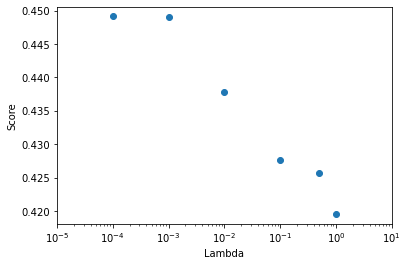

In [157]:
plt.scatter(lambdas,scores);
plt.xlabel("Lambda");
plt.ylabel('Score');
plt.xscale('log');
plt.xlim([1e-5,10])

Modelo com lambda = 0.0001 apresentou o melhor score

In [158]:
modelo_final = Lasso(alpha=0.0001)
modelo_final.fit(lasso_x,y)
lasso_pred = modelo_final.predict(lasso_x)

Vamos visualizar como a regressão de lasso está se comportando em relação aos atributos:

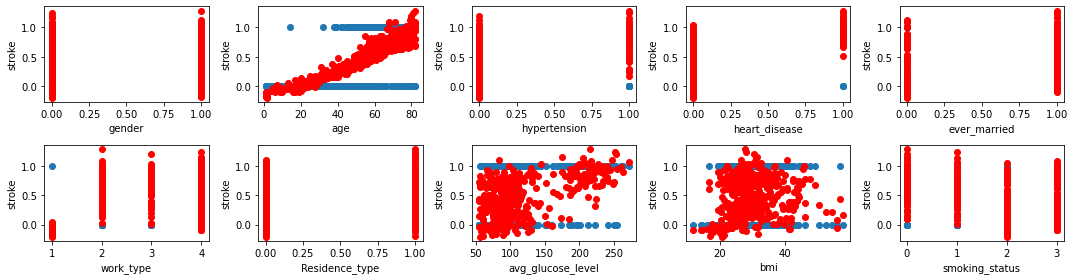

In [159]:
fig, ax = plt.subplots(2,5,figsize=(15, 4))
ax[0][0].scatter(lasso_X[:,0],y);
ax[0][0].scatter(lasso_X[:,0],lasso_pred, color ='red');
ax[0][0].set_xlabel('gender');
ax[0][0].set_ylabel('stroke');

ax[0][1].scatter(lasso_X[:,1],y);
ax[0][1].scatter(lasso_X[:,1],lasso_pred, color = 'red');
ax[0][1].set_xlabel('age');
ax[0][1].set_ylabel('stroke');

ax[0][2].scatter(lasso_X[:,2],y);
ax[0][2].scatter(lasso_X[:,2],lasso_pred,color ='red');
ax[0][2].set_xlabel('hypertension');
ax[0][2].set_ylabel('stroke');

ax[0][3].scatter(lasso_X[:,3],y);
ax[0][3].scatter(lasso_X[:,3],lasso_pred,color ='red');
ax[0][3].set_xlabel('heart_disease');
ax[0][3].set_ylabel('stroke');

ax[0][4].scatter(lasso_X[:,4],y);
ax[0][4].scatter(lasso_X[:,4],lasso_pred,color ='red');
ax[0][4].set_xlabel('ever_married');
ax[0][4].set_ylabel('stroke');

ax[1][0].scatter(lasso_X[:,5],y);
ax[1][0].scatter(lasso_X[:,5],lasso_pred, color ='red');
ax[1][0].set_xlabel('work_type');
ax[1][0].set_ylabel('stroke');

ax[1][1].scatter(lasso_X[:,6],y);
ax[1][1].scatter(lasso_X[:,6],lasso_pred, color = 'red');
ax[1][1].set_xlabel('Residence_type');
ax[1][1].set_ylabel('stroke');

ax[1][2].scatter(lasso_X[:,7],y);
ax[1][2].scatter(lasso_X[:,7],lasso_pred,color ='red')
ax[1][2].set_xlabel('avg_glucose_level');
ax[1][2].set_ylabel('stroke');

ax[1][3].scatter(lasso_X[:,8],y);
ax[1][3].scatter(lasso_X[:,8],lasso_pred,color ='red');
ax[1][3].set_xlabel('bmi');
ax[1][3].set_ylabel('stroke');

ax[1][4].scatter(lasso_X[:,9],y);
ax[1][4].scatter(lasso_X[:,9],lasso_pred,color ='red');
ax[1][4].set_xlabel('smoking_status');
ax[1][4].set_ylabel('stroke');

plt.tight_layout();

Observa-se que ela tem uma boa eficácia em atributos com valores contínuos

In [160]:
lasso_x[:5]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
710,1,79,0,0,1,3,0,131.85,25.9,2
837,1,39,0,0,0,2,1,79.44,22.7,3
102,1,74,0,0,1,4,0,231.61,34.6,0
749,0,55,0,0,1,2,0,65.12,30.0,3
684,1,1,0,0,0,1,1,130.61,14.4,2


In [161]:
y[:5]

710    0
837    0
102    1
749    0
684    0
Name: stroke, dtype: int64

In [162]:
modelo_final.predict(lasso_x[:5])*100

array([79.62890189, 28.39600158, 90.11662065, 39.02270915, -9.54563094])

In [163]:
test = []
test = modelo_final.predict(lasso_x)>np.mean(lasso_pred)

Verificando a precisão e cobertura desse modelo

In [164]:
verify = 0
failed = 0
for i in range(418):
    if test[i] == True and y.values[i] == 1:
        verify +=1
    elif test [i] == False and y.values[i] == 0:
        verify +=1
    else:
        failed += 1
        
margem = verify / len(y.values) * 100
print("Acuracy: {:.1f}% ".format(margem))

Acuracy: 80.4% 


Observa-se uma acurácia satisfatória. Neste sentido, seria interessante aplicar a regressão de lasso como atributo em um dos modelos?

In [165]:
pred_db_lasso['stroke_scalar'] = lasso_pred > .5
lasso_x_etc = pred_db_lasso.drop('stroke', axis=1)
pred_db_lasso.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,stroke_scalar
710,1,79,0,0,1,3,0,131.85,25.9,2,0,True
837,1,39,0,0,0,2,1,79.44,22.7,3,0,False
102,1,74,0,0,1,4,0,231.61,34.6,0,1,True
749,0,55,0,0,1,2,0,65.12,30.0,3,0,False
684,1,1,0,0,0,1,1,130.61,14.4,2,0,False


Criando funções para verificar a precisão e cobertura

In [166]:
from random import sample

def acuracy(model, atrib_test, val_test, quant):
    averages = []
    
    for i in range(quant):
        index = sample(range(len(atrib_test)), 5)
        
        predict = model.predict(atrib_test.iloc[index])
        result = val_test.iloc[index]
        
        mean = (predict == result).sum() * 20
        averages.append(mean)
    
    return np.mean(averages)

In [167]:
def score(model, atrib_train, val_train, atrib_test, val_test, quant):
    scores = []
    for i in range(quant):
        m = model
        m.fit(atrib_train, val_train)

        scores.append(acuracy(m, atrib_test, val_test, 20))

    return np.mean(scores)

 Preparando os dados para aplicação do modelo ExtraTreesClassfier

In [168]:
from sklearn.model_selection import train_test_split

In [169]:
# Criando os conjuntos de dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(lasso_x_etc, y, test_size = 0.4)

In [170]:
# Verificando a separação do conjunto de amostras
len(x_train.index) + len(x_test.index) == len(x.index)

True

### 3. Árvore de Classificação

In [171]:
from sklearn.ensemble import ExtraTreesClassifier

In [172]:
# Criação do modelo
model = ExtraTreesClassifier()
model.fit(x_train, y_train)

ExtraTreesClassifier()

Verificando a importância de cada atributo no modelo de árvore de classificação:

In [173]:
attrib = lasso_x_etc.columns.to_list()
importances = model.feature_importances_

for a, i in zip(attrib, importances):
    print('{} = {:.2f}%'.format(a.title(), i * 100))

Gender = 3.65%
Age = 22.63%
Hypertension = 3.58%
Heart_Disease = 3.03%
Ever_Married = 3.94%
Work_Type = 5.18%
Residence_Type = 2.94%
Avg_Glucose_Level = 15.27%
Bmi = 12.65%
Smoking_Status = 6.34%
Stroke_Scalar = 20.79%


In [174]:
result = model.score(x_test, y_test)
print('Acurácia:', round(result * 100, 2))

Acurácia: 81.55


In [175]:
x_test[:5]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke_scalar
56,1,82,0,0,1,4,0,59.32,33.2,3,True
166,1,56,0,0,1,2,0,162.23,27.3,2,True
134,1,68,1,0,1,3,0,206.09,26.7,3,True
826,1,36,1,0,1,4,1,91.56,42.2,3,False
99,1,69,0,0,1,2,1,82.81,28.0,3,True


In [176]:
prediction = model.predict(x_test[0:5])
prediction

array([1, 1, 1, 0, 1], dtype=int64)

In [177]:
y_test[:5]

56     1
166    1
134    1
826    0
99     1
Name: stroke, dtype: int64

Verificando a precisão e cobertura do modelo

In [178]:
acuracy(model, x_test, y_test, 50)

84.4

In [179]:
score(ExtraTreesClassifier(), x_train, y_train, x_test, y_test, 5)

80.4

Observam-se resultados satisfatórios na aplicação desse modelo. Contudo, será treinado outro modelo de machine learning para a comparação de acurácia.

Preparação dos dados de treino e teste para aplicação do modelo Multi-layer Perceptron

Retirada de alguns valores contínuos que estavam prejudicando o classificador

In [180]:
x = x.drop('avg_glucose_level',axis=1)
x = x.drop('bmi',axis=1)

In [181]:
x.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
710,1,79,0,0,1,3,0,2
837,1,39,0,0,0,2,1,3
102,1,74,0,0,1,4,0,0
749,0,55,0,0,1,2,0,3
684,1,1,0,0,0,1,1,2


In [182]:
# Só recriamos pois como não temos a coluna "stroke_scalar" vamos precisar de novos dados de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5)

In [183]:
# Verificando a separação do conjunto de amostras
len(x_train.index) + len(x_test.index) == len(x.index)

True

### 4. Rede Neural Multi-layer Perceptron

In [184]:
from sklearn.neural_network import MLPClassifier

In [185]:
clf = MLPClassifier(solver='adam', alpha=1e-5,activation='logistic', max_iter= 1000)

In [186]:
clf.fit(x, y)

MLPClassifier(activation='logistic', alpha=1e-05, max_iter=1000)

In [187]:
x_test[:5]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
735,0,73,0,0,1,4,1,3
237,0,77,0,0,1,3,0,0
68,0,59,0,0,1,4,1,0
706,1,66,0,0,1,2,0,1
157,1,57,0,0,1,4,1,1


In [188]:
proba = clf.predict_proba(x_test[:5])*100
proba

array([[34.73688172, 65.26311828],
       [18.27039084, 81.72960916],
       [38.83536029, 61.16463971],
       [29.03575666, 70.96424334],
       [51.7003386 , 48.2996614 ]])

In [189]:
clf.predict(x_test[:5])

array([1, 1, 1, 1, 0], dtype=int64)

In [190]:
y_test[:5]

735    0
237    1
68     1
706    0
157    1
Name: stroke, dtype: int64


Verificando a precisão e cobertura desse modelo

In [191]:
acuracy(clf, x_test, y_test, 100)

79.2

In [192]:
score(clf, x_train, y_train, x_test, y_test, 5)

81.6

#### Analisando o comportamento da rede neural em relação ao atributo "age"

Tomemos um indivíduo como referência para verificar o impacto da alteração do atributo contínuo tratado na previsão da possibilidade de se ter um AVC. Adotamos, inicialmente, as seguintes características:
- Gênero masculino (1)
- Não hipertenso (0)
- Sem histórico de doenças do coração (0)
- Solteiro (0)
- Trabalha em empresa privada (0)
- Residindo em meio urbano (0)
- Nunca fumou (0)

In [193]:
attr = {'Idade':list(range(int(db.age.min()), int((db.age.max()))))}

In [194]:
proba_age = [clf.predict_proba([[1, i, 0, 0, 0, 0, 0, 0]])[0][1]*100 for i in attr['Idade']]

attr['Idade'] = [attr['Idade'], proba_age]

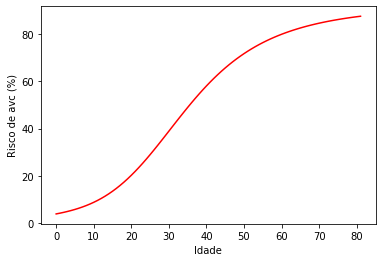

In [195]:
plt.plot(attr['Idade'][0],attr['Idade'][1], color='red');
plt.xlabel("Idade");
plt.ylabel('Risco de avc (%)');

As informações observadas no gráfico estão em coerência com as análises realizadas anteriormente. Demonstra ainda uma menor taxa de crescimento até os 40 anos, momento em que os riscos começam a aumentar de forma mais acentuada.

### 5. Interface

Criação de um sistema de predição com interface, baseada no modelo MLPClassifier, visto que ele obteve a melhor acurácia nos testes realizados.

In [196]:
import datetime
# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
from ipywidgets import IntSlider
style = {'description_width': 'initial'}
import ipywidgets as widgets
# defining some widgets
menu_gender = widgets.Dropdown(
    options={"Female":0,"Male":1},
    description='Your Gender:')
calendar = widgets.DatePicker(
           description='Date of birth: ')
checkbox = widgets.Checkbox(
           description='Check to invert',style = style)
menu_hipertension = widgets.Dropdown(
    options={"Yes":1,"No":0},
    description='Have hypertension?',style = style)
menu_heart_disease = widgets.Dropdown(
    options={"Yes":1,"No":0},
    description='Have heart disease?', style = style)
menu_ever_married = widgets.Dropdown(
    options={"Yes":0,"No":1},
    description='You married?')
menu_work_type = widgets.Dropdown(
    options={'Private': 0, 'Self-employed':1, 'Govt_job':2, 'children':3, 'Never worked':4},
    description='What you work type? ',style = style)
menu_residence_type = widgets.Dropdown(
    
    options={'Urban': 1, 'Rural':0},
    description='What you residence type?',style = style)
menu_smoke_status = widgets.Dropdown(
    options={'Never smoke': 3, 'Unknown':2, 'formaly smoked':0, 'smokes':1},
    description='Smoke status:',style = style)

buttonuser_info = widgets.Button(description='Result')
outuser_info = widgets.Output()
def on_buttonuser_info_clicked(b):
    if type(calendar.value) != (datetime.date):
        return display(Markdown("Please enter a date!"))        
    with outuser_info:
        year_user = calendar.value.year
        year_today = datetime.date.today().year
        user_month = calendar.value.month
        month_today = datetime.date.today().month
        user_day = calendar.value.day
        day_today = datetime.date.today().day
        age = year_today - year_user
       
        if user_month >= month_today:
            if user_day <= day_today:
                age -= 1
        result = [[menu_gender.value, age, menu_hipertension.value, menu_heart_disease.value ,menu_ever_married.value,
               menu_work_type.value, menu_residence_type.value, menu_smoke_status.value]]
        proba = (clf.predict_proba(result))*100
        display(Markdown("Your probability of having a stroke is: {:.1f}%\n \
                        \nOur prediction has an accuracy of {}% hits. But don't worry, we can get it wrong :)" .format(proba[0][1],acuracy(clf, x_test, y_test, 100))))
    

buttonuser_info.on_click(on_buttonuser_info_clicked)
display(widgets.VBox([menu_gender, calendar, menu_hipertension, menu_heart_disease, menu_ever_married, menu_work_type,
                    menu_residence_type, menu_smoke_status,buttonuser_info,outuser_info]))

Please enter a date!

## Conclusão: 

Durante a pesquisa foi possível obter os seguintes resultados:
- Verificar a distribuição dos atributos contidos nos dados pertinentes à pesquisa;
- Montar a partir da, exploração e agrupamentos dos dados, perfís indicativos da ocorrência de AVC;
- Treinar modelos de machine learning capazes de, com menor ou maior acurácia, predizerem a ocorrência do AVC.

Os resultados obtidos foram importantes por permitirem compreender e parametrizar objetivamente a probabilidade de ocorrência do AVC, com base no dataset de indíviduos com variadas características. Tais resultados se coadunam com os recentes avanços na medicina utilizando recursos da ciência de dados em seu suporte.

Nesta pesquisa foi observada a carência de dados confiáveis e públicos a respeito do tema tratado, sendo essencial para o aprimoramento das pesquisas realizadas nessa área a conscientização das instituições de saúde para a formação de bases de dados que possibilitem os suporte de tais pesquisas. Ademais, a discrepância entre os indivíduos com e sem AVC nos dados disponíveis dificultou as análises e a aplicação dos modelos de predição.

Como propostas para possíveis melhorias na pesquisa:
- Aplicação das análises e modelos preditivos em outros datasets visando sua comparação;
- Compreender o funcionamento dos modelos de machine learning para sua aplicação de maneira mais eficiente.

Por fim, se faz latente a necessidade de trabalhos futuros aplicando tais modelos de predição a dados que retratem a realidade de pacientes acometidos de AVC no Brasil. Aplicando os resultados encontrados em indivíduos brasileiros visando sua disponibilidade na saúde pública.